### Basic principles
    1. phase difference at HHLM output
    2. subtract fitted 2nd order phase to get plate thickness
    3. scan m2_p again with phase plate
    

In [1]:
from Functions import *
import winsound
from skimage.restoration import unwrap_phase

In [2]:
from lmfit.models import PseudoVoigtModel

In [3]:
FOV1 = 5e-3; N1 = 512
FOV2 = 5e-3; N2 = 10240

# Preliminary

In [4]:
def define_beamline_normal(
    E0, m1_p=185.0, m1_q=-25.6, m2_p=141.6, m2_q=1e5,
    HHLM_type='2DCM', HHLM_offset=20e-3, pair_distance=200e-3,
    slit_width=3e-6, f1=10.0, f2=10.0,
    hkl1 = [1,1,1], alphaAsym1 = 0.0,
    hkl2 = [2,2,0], alphaAsym2 = 0.0,
    hkl3 = [5,5,5], alphaAsym3 = 15.0,
    shapeErrors=[None for i in range(6)],
    l_crystal=[1e-1 for i in range(6)],
    w_crystal = [5e-3 for i in range(6)]):
    
    z_s = 650

    # viewing point - upstream of monochromator
    im_input = optics.PPM('im_input', z=184+z_s, FOV=FOV1, N=N1)
    
    Telescope_devices = define_Telescope(E0, m1_p=m1_p, m1_q=m1_q, m2_p=m2_p, m2_q=m2_q)
    
    if HHLM_type == '2DCM':
        HHLM_devices = define_HHLM_2DCM(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    elif HHLM_type == 'Zigzag':
        HHLM_devices = define_HHLM_Zigzag(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    
    im_plate = optics.PPM('im_plate', FOV=FOV2, N=N2,z=HHLM_devices[-1].z + 1e-3)
    
    HRM_devices = define_HRM(E0, f1=f1, f2=f2, slit_width=slit_width,
                            hkl=hkl3, alphaAsym=alphaAsym3,
                            shapeErrors=shapeErrors,
                            l_crystal=l_crystal,
                            w_crystal=w_crystal)
    
    im_plate2 = optics.PPM('im_plate2', FOV=FOV2, N=512,z=HRM_devices[-1].z+1e-3)
    
    im_output = optics.PPM('im_output', FOV=FOV1,N=N1,z=HRM_devices[-1].z+1.1e-3)

    all_devices = [im_input] + Telescope_devices + HHLM_devices + [im_plate] + HRM_devices + [im_plate2, im_output]
    
    mono_beamline = beamline.Beamline(all_devices, ordered=True)
    return all_devices, mono_beamline

In [1]:
# m1_q calculation
0.13776021444444445*9000

1239.84193

### 1. common simulation parameters

In [5]:
##### ''' Beam parameters '''
N = 1024          # number of sampling points
E0 = 9481        # photon energy [eV]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 23e-6,
    'sigma_y': 23e-6,
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 650-26
}

##### common simulation parameters
m1_p = 185.0; m1_q = -58.0
m2_p = 175.75675470970143

# m2_p1 = 191.62305868341930    # 10% all correction value
# m2_p1 = 214.76851459045074    # 20% all correction value
# m2_p1 = 247.07409281974265    # 30% all correction value
# m2_p1 = 286.75140563481887    # 40% all correction value
# m2_p1 = 352.19312731548010    # 50% all correction value
# m2_p1 = 444.54120500899210    # 60% all correction value
# m2_p1 = 703.63954095253210    # 70% all correction value
# m2_p1 = 1354.7158583823289    # 80% all correction value

# m2_p1 = 187.39304819504640    # 10% w/o HRM
# m2_p1 = 207.59520910595688    # 20% w/o HRM
# m2_p1 = 274.07409281974265    # 30% w/o HRM
# m2_p1 = 258.76471110157040    # 40% w/o HRM
# m2_p1 = 299.05669661735806    # 50% w/o HRM
# m2_p1 = 354.62781617430744    # 60% w/o HRM
# m2_p1 = 476.90254085599730    # 70% w/o HRM
m2_p1 = 641.29475248046820    # 80% w/o HRM

power_percentage = 80

f1 = 10.0; f2 = 10.0            # f1: crystal-mirror distance, f2: mirror focal distance

HHLM_type = 'Zigzag'              # 2DCM or Zigzag
HHLM_offset=20e-3
pair_distance=200e-3
hkl1 = [1,1,1]; alphaAsym1 = 9.0    # asymmetry angle for the 1st pair of HHLM crystal
hkl2 = [2,2,0]; alphaAsym2 = 0.0    # ````````````````````````2nd pair of HHLM crystal
hkl3 = [4,4,0]; alphaAsym3 = 15.0   # ````````````````````````2nd and 3rd HRM crystal

# list of crystals
crystals = np.array(['HHLM1', 'HHLM2', 'HHLM3', 'HHLM4', 'C1', 'C2']); n_crys = len(crystals)

##### I/O
dir_out = 'output/'; make_dir(dir_out)
dir_ev = dir_out + '{}eV/'.format(E0); make_dir(dir_ev)
dir_case = dir_ev + 'm2_p_optimization/'; make_dir(dir_case)

print('\nCWD:',dir_case)

dir_plot = dir_case+'{}_{}_{}/'.format(HHLM_type, hkl1[0]*100+hkl1[1]*10+hkl1[2],
                                      hkl2[0]*100+hkl2[1]*10+hkl2[2]); make_dir(dir_plot)
dir_plot += '{}_{}_deg_{}mm_offset/'.format(alphaAsym1, alphaAsym2, 1e3*HHLM_offset); make_dir(dir_plot)


path exists
path exists
path exists

CWD: output/9481eV/m2_p_optimization/
path exists
path exists


### 2. calculate crystal dimensions and slit width

In [6]:
%%capture capt

# simulation parameters for the normal condition
slit_width = 1e-1
shapeErrors = [None for i in range(6)]
l_crystal = [1e-1 for i in range(6)]
w_crystal = [5e-3 for i in range(6)]

mono_devices_calc, mono_beamline_calc = define_beamline_normal(E0,
                               m1_p=m1_p, m1_q=m1_q, m2_p=m2_p,
                               HHLM_type=HHLM_type,
                               HHLM_offset=HHLM_offset,
                               pair_distance=pair_distance,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=shapeErrors,
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

b1_calc = beam.Beam(beam_params=beam_params)
b2_calc = mono_beamline_calc.propagate_beamline(b1_calc)

In [7]:
# get crytal properties
beta0s = []; braggs = []; asyms = []
for device in mono_devices_calc:
    if device.name in crystals:
        beta0s.append(device.beta0)
        braggs.append(np.rad2deg(device.bragg))
        asyms.append(np.rad2deg(device.alphaAsym))

# calculate beam FWHM after each crystal
wx1, wy1 = mono_beamline_calc.im_after_HHLM1.beam_analysis(mono_beamline_calc.im_after_HHLM1.get_profile_x(), mono_beamline_calc.im_after_HHLM1.get_profile_y())[2:4]
wx2, wy2 = mono_beamline_calc.im_after_HHLM2.beam_analysis(mono_beamline_calc.im_after_HHLM2.get_profile_x(), mono_beamline_calc.im_after_HHLM2.get_profile_y())[2:4]
wx3, wy3 = mono_beamline_calc.im_after_HHLM3.beam_analysis(mono_beamline_calc.im_after_HHLM3.get_profile_x(), mono_beamline_calc.im_after_HHLM3.get_profile_y())[2:4]
wx4, wy4 = mono_beamline_calc.im_after_HHLM4.beam_analysis(mono_beamline_calc.im_after_HHLM4.get_profile_x(), mono_beamline_calc.im_after_HHLM4.get_profile_y())[2:4]
wx5, wy5 = mono_beamline_calc.im_after_C1.beam_analysis(mono_beamline_calc.im_after_C1.get_profile_x(), mono_beamline_calc.im_after_C1.get_profile_y())[2:4]
wx6, wy6 = mono_beamline_calc.im_after_C2.beam_analysis(mono_beamline_calc.im_after_C2.get_profile_x(), mono_beamline_calc.im_after_C2.get_profile_y())[2:4]
beam_size = np.array([wx1, wx2, wx3, wx4, wx5, wx6])    # FWHM

# crystal lengths (long) and widths (short) [m]
l_crystal = np.divide(beam_size*2, np.sin(beta0s))
w_crystal = np.array([wy1, wy2, wy3, wy4, wy5, wy6])*2

print('bragg angle: {}'.format(np.round(braggs,3)))
print('asymmetry: {}'.format(np.round(asyms,3)))
print('beam size: {} mm'.format(np.round(beam_size*1e3, 3)))
print('footprint: {} mm\n'.format(np.round(l_crystal*1e3/2,  3)))


# calculate slit width
slit_width = calc_slit_width(wx6*2, b2_calc.lambda0, mono_beamline_calc.mir1.q)
print('calculated slit width: {}um'.format(round(slit_width*1e6,2)))

if slit_width < 3e-6: slit_width = 3e-6
print('actual slit width: {}um\n'.format(round(slit_width*1e6,2)))

bragg angle: [12.043 19.911 19.911 12.037 42.928 42.928]
asymmetry: [-9. -0.  0.  9.  0. 15.]
beam size: [8.854 8.854 8.841 1.31  1.31  0.724] mm
footprint: [24.665 25.999 25.96  24.664  1.923  1.546] mm

calculated slit width: 0.84um
actual slit width: 3.0um



### 3. load shapeErrors

80%_shapeError_23.998W_8.169W_0.197W_0.188W_0.0W_0.0W
(5637, 2)


c:\users\nanw0\anaconda3\envs\lcls\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


(4517, 2)
(4517, 2)
(5637, 2)


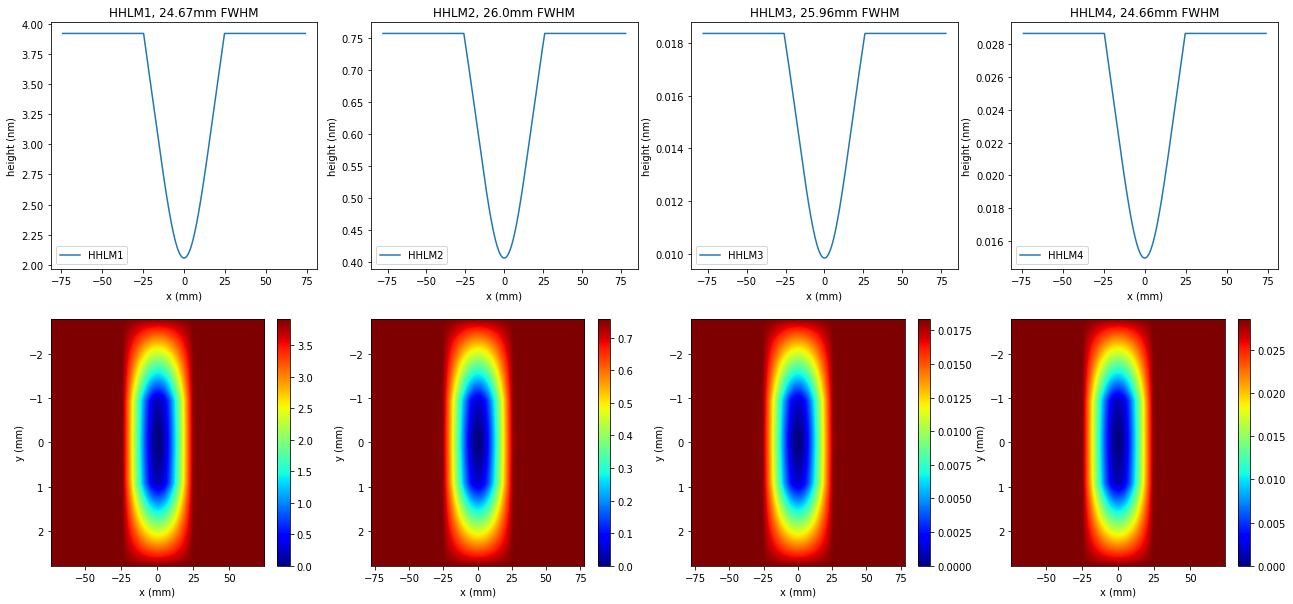

In [8]:
if_pad = 1

# crystal_powers = np.array([29.9778, 0.7356, 0.7410, 1.6837, 10.9076, 0.4703])*power_percentage/100    # crytal power for Zigzag-111-220 asymmetric
crystal_powers = np.array([29.9978, 10.2117, 0.2467, 0.2344, 3.4120, 0.4440])*power_percentage/100    # crytal power for Zigzag-111-220 symmetric
# crystal_powers = np.array([29.9552, 1.0849, 6.3846, 0.8192, 5.8204, 0.4589])*power_percentage/100    # crytal power for 2DCM-111-220 asymmetric, 16.9
# crystal_powers = np.array([29.9552, 1.0849, 10.3877, 0.1849, 2.4811, 0.4364])*power_percentage/100    # crytal power for 2DCM-111-220 asymmetric, 9.0
# crystal_powers = np.array([29.9552, 1.0849, 9.1635, 0.2965, 3.5789, 0.4476])*power_percentage/100    # crytal power for 2DCM-111-220 asymmetric, 13.0

crystal_powers *= np.array([1,1,1,1,0,0])

# directories
dir_profile = '../DXS_Xtals_FEA4WFS/{}/'.format(HHLM_type)

# get file name based on crystal powers
fname_error = '{}%_shapeError'.format(power_percentage)
for i in range(n_crys):
    fname_error += '_{}W'.format(round(crystal_powers[i],3))
print(fname_error)

# holders
shapeErrors = [None for i in range(n_crys)]
x_mirs      = [None for i in range(n_crys)]
y_mirs      = [None for i in range(n_crys)]

if HHLM_type == 'Zigzag':
    crystal_profile_powers = np.array([
        [73.15, 16.53, 0.029, 0.027, 0.026, 0.03],
        [73.15, 16.79, 0.015, 0.015, 0.014, 0.013],
        [4.51, 50.1, 1.78, 1.69, 1.61, 1.88]
    ])
elif HHLM_type == '2DCM':
    crystal_profile_powers = np.array([
        [73.15, 0.027, 16.53, 0.029, 0.026, 0.03],
        [73.15, 0.015, 16.79, 0.015, 0.014, 0.013],
        [4.51, 1.69, 50.1, 1.78, 1.61, 1.88]
    ])

# choose shapeError profiles with the closest power
ratio_power = crystal_profile_powers/np.stack([crystal_powers for i in range(3)])
ratio_power[ratio_power<1] = 1/(ratio_power[ratio_power<1])
options = ratio_power.argmin(axis=0)+1

# load
for i, crystal in enumerate(crystals):
    if crystal_powers[i] == 0: continue
    # load profiles from file
    dy, xx, zz = load_crystal_data(dir_profile, crystal, options[i])
    # proportionality constant due to power and crystal dimension
    height_factor1 = crystal_powers[i] / crystal_profile_powers[options[i]-1, i]    
    height_factor2 = (l_crystal[i]*1e3/(xx.max()-xx.min()))*(w_crystal[i]*1e3/(zz.max()-zz.min()))
    shapeErrors[i] = dy*1e6 * height_factor1 / height_factor2    # [nm]
    nx, ny = shapeErrors[i].shape; end_val = shapeErrors[i].max()
    if if_pad == 1:
        # stretch in both directions
        shapeErrors[i] = np.pad(shapeErrors[i],
                                pad_width=((nx,nx),(ny,ny)), mode='linear_ramp',
                                end_values = ((end_val,end_val),(end_val,end_val)))
        # modify dimensions for the new profile
        l_crystal[i] *= 3; w_crystal[i] *= 3
        # new crytal axis
        x_mirs[i] = np.linspace(-l_crystal[i]/2, l_crystal[i]/2, ny*3)
        y_mirs[i] = np.linspace(-w_crystal[i]/2, w_crystal[i]/2, nx*3)
    else:
        x_mirs[i] = np.linspace(-l_crystal[i]/2, l_crystal[i]/2, ny)
        y_mirs[i] = np.linspace(-w_crystal[i]/2, w_crystal[i]/2, nx)


# plot
n_subplot = np.sum(crystal_powers!=0)
plt.figure(figsize=(n_subplot*5+2, 10))
i_plot = 0
for i in range(n_crys):
    if crystal_powers[i] == 0: continue
    i_plot += 1
    plt.subplot(2, n_subplot, i_plot)
    plt.plot(x_mirs[i]*1e3, shapeErrors[i][1024,:], label=crystals[i])
    plt.legend(); plt.xlabel('x (mm)'); plt.ylabel('height (nm)')
    if if_pad == 1:
        plt.title('{}, {}mm FWHM'.format(crystals[i], round(l_crystal[i]/2*1e3/3,2)))
    else:
        plt.title('{}, {}mm FWHM'.format(crystals[i], round(l_crystal[i]/2*1e3,2)))
    plt.subplot(2, n_subplot, i_plot+n_subplot)
    plt.imshow(shapeErrors[i], cmap='jet',
              extent = [x_mirs[i].min()*1e3, x_mirs[i].max()*1e3, y_mirs[i].max()*1e3, y_mirs[i].min()*1e3])
    plt.colorbar(); plt.xlabel('x (mm)'); plt.ylabel('y (mm)'); plt.axis('tight')
    
plt.savefig(dir_plot+'Bumps_'+fname_error+'.png')

# Phase plate calculation

### 1. simulate the output of a monochromatic incident pulse w/ & w/o shapeError

In [9]:
%%capture capt

# open/close slit for phase difference calculation
slit_width = 1e-1

##### perfect
mono_devices_p, mono_beamline_p = define_beamline_normal(E0,
                           m1_p=m1_p, m1_q=m1_q, m2_p=m2_p,
                           HHLM_type=HHLM_type,
                           HHLM_offset=HHLM_offset,
                           pair_distance=pair_distance,
                           slit_width=slit_width, f1=f1, f2=f2,
                           hkl1=hkl1, alphaAsym1=alphaAsym1,
                           hkl2=hkl2, alphaAsym2=alphaAsym2,
                           hkl3=hkl3, alphaAsym3=alphaAsym3,
                           shapeErrors=[None for i in range(6)],
                           l_crystal=l_crystal,
                           w_crystal=w_crystal)

beam_params['photonEnergy'] = E0
b1_p = beam.Beam(beam_params=beam_params)
b2_p = mono_beamline_p.propagate_beamline(b1_p)

##### shapeError and mirror bending
mono_devices_m, mono_beamline_m = define_beamline_normal(E0,
                           m1_p=m1_p, m1_q=m1_q, m2_p=m2_p1,
                           HHLM_type=HHLM_type,
                           HHLM_offset=HHLM_offset,
                           pair_distance=pair_distance,
                           slit_width=slit_width, f1=f1, f2=f2,
                           hkl1=hkl1, alphaAsym1=alphaAsym1,
                           hkl2=hkl2, alphaAsym2=alphaAsym2,
                           hkl3=hkl3, alphaAsym3=alphaAsym3,
                           shapeErrors=shapeErrors,
                           l_crystal=l_crystal,
                           w_crystal=w_crystal)

beam_params['photonEnergy'] = E0
b1_m = beam.Beam(beam_params=beam_params)
b2_m = mono_beamline_m.propagate_beamline(b1_m)

### 2. get phase info from the outputs and convert to phase plate thickness

Text(0, 0.5, 'y (mm)')

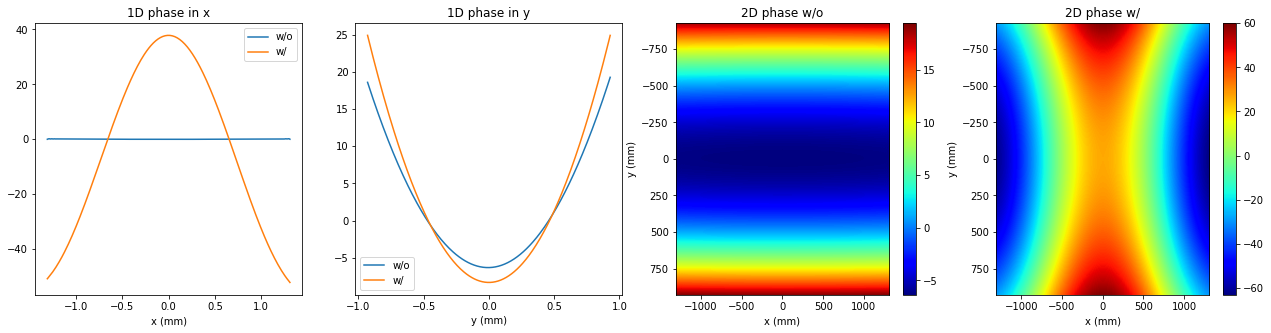

In [10]:
##### getting phase info
ppm_p = mono_beamline_p.im_plate
ppm_m = mono_beamline_m.im_plate
x_plate = 2*ppm_p.get_x_width(); y_plate = 2*ppm_p.get_y_width()
# x_plate = 2*ppm_p.get_x().max(); y_plate = 2*ppm_p.get_y().max()

# crop roi based on beam width
index_x = np.where((ppm_p.x **2) < ((x_plate/2) ** 2))[0]
index_y = np.where((ppm_p.y **2) < ((y_plate/2) ** 2))[0]
axis_x = np.linspace(-x_plate/2, x_plate/2, index_x[-1] - index_x[0] + 1)*1e3
axis_y = np.linspace(-y_plate/2, y_plate/2, index_y[-1] - index_y[0] + 1)*1e3

# if extract phase difference at end of HRM
# ppm_p = mono_beamline_p.im_plate2
# ppm_m = mono_beamline_m.im_plate2

# 1D phase info
phase_p_x = ppm_p.x_phase[index_x[0]:index_x[-1]+1]
phase_p_y = ppm_p.y_phase[index_y[0]:index_y[-1]+1]
phase_m_x = ppm_m.x_phase[index_x[0]:index_x[-1]+1]
phase_m_y = ppm_m.y_phase[index_y[0]:index_y[-1]+1]

# 2D phase info
# phase_p_2d = np.unwrap(np.angle(ppm_p.complex_beam()[0]))[index_y[0]:index_y[-1]+1, index_x[0]:index_x[-1]+1]
# phase_m_2d = np.unwrap(np.angle(ppm_m.complex_beam()[0]))[index_y[0]:index_y[-1]+1, index_x[0]:index_x[-1]+1]

phase_p_2d = unwrap_phase(np.angle(ppm_p.complex_beam()[0]), wrap_around=(False, False))[index_y[0]:index_y[-1]+1, index_x[0]:index_x[-1]+1]
phase_m_2d = unwrap_phase(np.angle(ppm_m.complex_beam()[0]), wrap_around=(False, False))[index_y[0]:index_y[-1]+1, index_x[0]:index_x[-1]+1]

# plots
plt.figure(figsize=(22,5))
plt.subplot(1,4,1)
plt.plot(axis_x, phase_p_x - np.median(phase_p_x), label='w/o')
plt.plot(axis_x, phase_m_x - np.median(phase_m_x), label='w/')
plt.legend()
plt.title('1D phase in x'); plt.xlabel('x (mm)')

plt.subplot(1,4,2)
plt.plot(axis_y, phase_p_y - np.median(phase_p_y), label='w/o')
plt.plot(axis_y, phase_m_y - np.median(phase_m_y), label='w/')
plt.legend()
plt.title('1D phase in y'); plt.xlabel('y (mm)')

plt.subplot(1,4,3)
plt.imshow(phase_p_2d-np.median(phase_p_2d), cmap='jet',
           extent = [axis_x.min()*1e3, axis_x.max()*1e3, axis_y.max()*1e3, axis_y.min()*1e3])
plt.colorbar()
plt.title('2D phase w/o'); plt.axis('tight')
plt.xlabel('x (mm)'); plt.ylabel('y (mm)')

plt.subplot(1,4,4)
plt.imshow(phase_m_2d-np.median(phase_m_2d), cmap='jet',
           extent = [axis_x.min()*1e3, axis_x.max()*1e3, axis_y.max()*1e3, axis_y.min()*1e3])
plt.colorbar()
plt.title('2D phase w/'); plt.axis('tight')
plt.xlabel('x (mm)'); plt.ylabel('y (mm)')

In [11]:
def polyfit2d(x, y, z, kx=3, ky=3, order=None):
    '''
    Two dimensional polynomial fitting by least squares.
    Fits the functional form f(x,y) = z.

    Notes
    -----
    Resultant fit can be plotted with:
    np.polynomial.polynomial.polygrid2d(x, y, soln.reshape((kx+1, ky+1)))

    Parameters
    ----------
    x, y: array-like, 1d
        x and y coordinates.
    z: np.ndarray, 2d
        Surface to fit.
    kx, ky: int, default is 3
        Polynomial order in x and y, respectively.
    order: int or None, default is None
        If None, all coefficients up to maxiumum kx, ky, ie. up to and including x^kx*y^ky, are considered.
        If int, coefficients up to a maximum of kx+ky <= order are considered.

    Returns
    -------
    Return paramters from np.linalg.lstsq.

    soln: np.ndarray
        Array of polynomial coefficients.
    residuals: np.ndarray
    rank: int
    s: np.ndarray

    '''

    # grid coords
    x, y = np.meshgrid(x, y)
    # coefficient array, up to x^kx, y^ky
    coeffs = np.ones((kx+1, ky+1))

    # solve array
    a = np.zeros((coeffs.size, x.size))

    # for each coefficient produce array x^i, y^j
    for index, (j, i) in enumerate(np.ndindex(coeffs.shape)):
        # do not include powers greater than order
        if order is not None and i + j > order:
            arr = np.zeros_like(x)
        else:
            arr = coeffs[i, j] * x**i * y**j
        a[index] = arr.ravel()

    # do leastsq fitting and return leastsq result
    return np.linalg.lstsq(a.T, np.ravel(z), rcond=None)

(-1.3099071633217005, 1.3099071633217005)

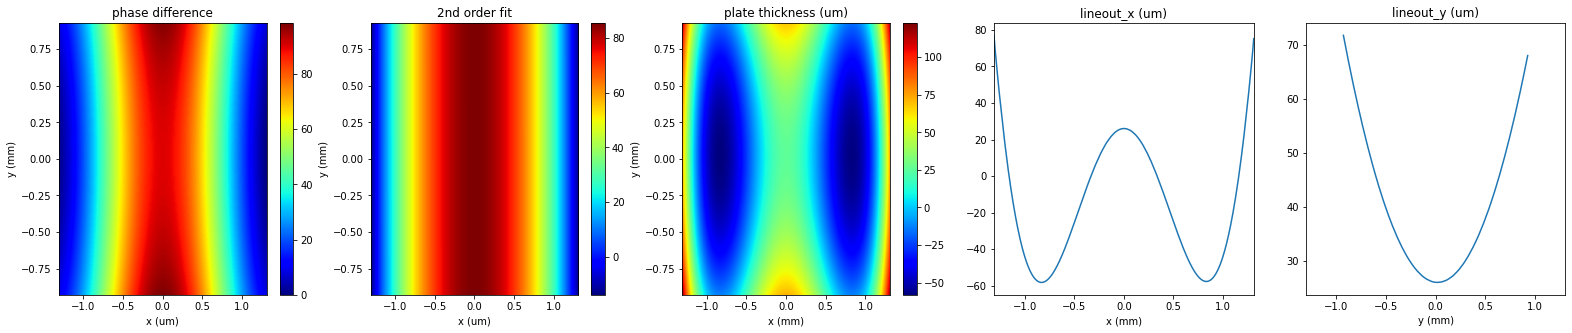

In [12]:
##### calculating phase difference and thickness
# phase advancement
phaseMap = phase_m_2d - phase_p_2d
phaseMap -= phaseMap.min()

# fit for 2nd order shapes
nx, ny = phaseMap.T.shape
fit_x = np.linspace(-1, 1, nx)
fit_y = np.linspace(-1, 1, ny)

soln = polyfit2d(fit_x, fit_y, phaseMap.T, kx=2, ky=2, order=2)

fit_x, fit_y = np.meshgrid(fit_x, fit_y)
fitted_surf = np.polynomial.polynomial.polyval2d(fit_x, fit_y, soln[0].reshape((3,3)))

# load material information from CXRO data
filename = os.path.join('../../LCLS/lcls_beamline_toolbox-beta/lcls_beamline_toolbox/xraybeamline2d/cxro_data/Be.csv')
cxro_data = np.genfromtxt(filename, delimiter=',')
energy = cxro_data[:, 0]; delta = cxro_data[:, 1]; beta = cxro_data[:, 2]
delta = np.interp(E0, energy, delta); beta = np.interp(E0, energy, beta)

# calculate thickness
plateThickness = (phaseMap-fitted_surf) * b2_p.lambda0 / (delta*2*np.pi)

x_min = -ppm_p.get_x_width()*1e3; x_max = ppm_p.get_x_width()*1e3
y_min = -ppm_p.get_y_width()*1e3; y_max = ppm_p.get_y_width()*1e3

# plots
plt.figure(figsize=(27,5))
plt.subplot(1,5,1)
plt.imshow(phaseMap, cmap='jet',
           extent = [-wx4*1e3, wx4*1e3, wy4*1e3, -wy4*1e3])
plt.colorbar(); plt.axis('tight')
plt.title('phase difference')
plt.xlabel('x (um)'); plt.ylabel('y (mm)')
plt.xlim([x_min, x_max]); plt.ylim([y_min, y_max])

plt.subplot(1,5,2)
plt.imshow(fitted_surf, cmap='jet',
           extent = [-wx4*1e3, wx4*1e3, wy4*1e3, -wy4*1e3])
plt.colorbar(); plt.axis('tight')
plt.title('2nd order fit')
plt.xlabel('x (um)'); plt.ylabel('y (mm)')
plt.xlim([x_min, x_max]); plt.ylim([y_min, y_max])

plt.subplot(1,5,3)
plt.imshow(plateThickness*1e6, cmap='jet',
           extent = [-wx4*1e3, wx4*1e3, wy4*1e3, -wy4*1e3])
plt.colorbar(); plt.axis('tight')
plt.title('plate thickness (um)')
plt.xlabel('x (mm)'); plt.ylabel('y (mm)')
plt.xlim([x_min, x_max]); plt.ylim([y_min, y_max])

plt.subplot(1,5,4)
plt.plot(axis_x, plateThickness[int(plateThickness.shape[0]/2)] * 1e6)
plt.xlabel('x (mm)'); plt.title('lineout_x (um)')
plt.xlim([x_min, x_max])

plt.subplot(1,5,5)
plt.plot(axis_y, plateThickness[:,int(plateThickness.shape[1]/2)] * 1e6)
plt.xlabel('y (mm)'); plt.title('lineout_y (um)')
plt.xlim([x_min, x_max])

# New class for PhasePlate optics

In [13]:
class PhasePlate:
    """
    Attributes
    ----------
    name: str
        Name of the device (e.g. CRL1)
    plateThickness: float
        Thickness profile of the phase plate. (meters)
    x_plate: float
        Phase plate size in x. (meters)
    y_plate: float
        Phase plate size in y. (meters)
    E0: float or None
        photon energy in eV for calculating the corresponding phase difference of a given thickness
    material: str
        Phase plate material. Currently only Be is implemented but may add CVD diamond in the future.
        Looks up downloaded data from CXRO.
    dx: float
        Phase plate de-centering along beam's x-axis.
    dy: float
        Phase plate de-centering along beam's y-axis.
    z: float
        z location of phase plate along beamline.
    energy: (N,) ndarray
        List of photon energies from CXRO file (eV).
    delta: (N,) ndarray
        Real part of index of refraction. n = 1 - delta + 1j * beta
    beta: (N,) ndarray
        Imaginary part of index of refraction. n = 1 - delta + 1j * beta
    """
    
    def __init__(self, name, plateThickness=None, x_plate=None, y_plate=None, E0=None, material='Be', z=0, dx=0, dy=0):
        """
        Method to create a PhasePlate object.
        :param name: str
            Name of the device (e.g. Phase1)
        :param plateThickness: float
            Thickness profile of the phase plate. (meters)
        :x_plate: float
            Phase plate size in x. (meters)
        :y_plate: float
            Phase plate size in y. (meters)
        :param E0: float
            photon energy for calculating radius of curvature for a given focal length (eV)
        :param material: str
            Lens material. Currently only Be is implemented but may add CVD diamond in the future.
            Looks up downloaded data from CXRO.
        :param z: float
            z location of lenses along beamline.
        :param dx, dy: float
            PhasePlate de-centering along beam's x,y-axis.
        :param orientation: int
            Whether or not this is a horizontal or vertical lens (0 for horizontal, 1 for vertical).
        """
        
        # set some attributes
        self.name = name
        self.plateThickness = plateThickness
        self.x_plate = x_plate
        self.y_plate = y_plate
        self.E0 = E0
        self.material = material
        self.dx = dx
        self.dy = dy
        self.z = z
        self.global_x = 0
        self.global_y = 0
        self.azimuth = 0
        self.elevation = 0
        self.xhat = None
        self.yhat = None
        self.zhat = None

        # get file name of CXRO data
        filename = os.path.join('../../LCLS/lcls_beamline_toolbox-beta/lcls_beamline_toolbox/xraybeamline2d/cxro_data/Be.csv')

        # load in CXRO data
        cxro_data = np.genfromtxt(filename, delimiter=',')
        self.energy = cxro_data[:, 0]
        self.delta = cxro_data[:, 1]
        self.beta = cxro_data[:, 2]

    def multiply(self, beam):
        """
        Method to propagate beam through PhasePlate
        :param beam: Beam
            Beam object to propagate through PhasePlate. Beam is modified by this method.
        :return: None
        """
        
        # get shape of phase plate thickness
        self.plate_shape = np.shape(self.plateThickness)
        Ms = self.plate_shape[0]; Ns = self.plate_shape[1]
        
        
        beamx = beam.x
        beamy = beam.y
        central_line_x = self.plateThickness[np.int(Ms/2)]
        central_line_y = self.plateThickness[:, np.int(Ns/2)]
        
        Ms = central_line_x.size; Ns = central_line_y.size
        xs = np.linspace(-Ms/2, Ms/2 -1, Ms) * self.x_plate/Ms    # phase plate x coordinate
        ys = np.linspace(-Ns/2, Ns/2 -1, Ns) * self.y_plate/Ns    # phase plate y coordinate
        
        # interpolation onto beam coordinates
        thickness_x = np.interp(beamx - self.dx, xs, central_line_x, left=0, right=0)
        thickness_y = np.interp(beamy - self.dy, ys, central_line_y, left=0, right=0)

        # interpolate to find index of refraction at beam's energy
        delta = np.interp(beam.photonEnergy, self.energy, self.delta)
        beta = np.interp(beam.photonEnergy, self.energy, self.beta)
        phase_x = -beam.k0 * delta * thickness_x
        phase_y = -beam.k0 * delta * thickness_y
        
        # transmission based on beta and thickness profile
        mask_x = (((beamx - self.dx) ** 2) < (self.x_plate / 2) ** 2).astype(float)
        mask_y = (((beamy - self.dy) ** 2) < (self.y_plate / 2) ** 2).astype(float)
        transmission_x = np.exp(-beam.k0 * beta * thickness_x) * np.exp(1j * phase_x) * mask_x
        transmission_y = np.exp(-beam.k0 * beta * thickness_y) * np.exp(1j * phase_y) * mask_y
        
        beam.wavex *= transmission_x
        beam.wavey *= transmission_y

    def propagate(self, beam):
        """
        Method to propagate beam through PhasePlate. Calls multiply.
        :param beam: Beam
            Beam object to propagate through PhasePlate. Beam is modified by this method.
        :return: None
        """
        self.multiply(beam)

# Beam profile simulation with the new PhasePlate optics

### new beamline function

In [14]:
def define_beamline_phase(
    E0, m1_p=185.0, m1_q=-25.6, m2_p=141.6, m2_q=1e5,
    HHLM_type='2DCM', HHLM_offset=20e-3, pair_distance=200e-3,
    slit_width=3e-6, f1=10.0, f2=10.0,
    hkl1 = [1,1,1], alphaAsym1 = 0.0,
    hkl2 = [2,2,0], alphaAsym2 = 0.0,
    hkl3 = [5,5,5], alphaAsym3 = 15.0,
    shapeErrors=[None for i in range(6)],
    l_crystal=[1e-1 for i in range(6)],
    w_crystal = [5e-3 for i in range(6)]):
    
    z_s = 650

    # viewing point - upstream of monochromator
    im_input = optics.PPM('im_input', z=184+z_s, FOV=FOV1, N=N1)
    
    Telescope_devices = define_Telescope(E0, m1_p=m1_p, m1_q=m1_q, m2_p=m2_p, m2_q=m2_q)
    
    if HHLM_type == '2DCM':
        HHLM_devices = define_HHLM_2DCM(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    elif HHLM_type == 'Zigzag':
        HHLM_devices = define_HHLM_Zigzag(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    
    Phase1 = PhasePlate('Phase1', plateThickness=plateThickness, x_plate=x_plate, y_plate=y_plate, E0=E0, z= HHLM_devices[-1].z)
    im_plate = optics.PPM('im_plate', FOV=FOV2, N=N2, z=HHLM_devices[-1].z+1.1e-3)
    
    HRM_devices = define_HRM(E0, f1=f1, f2=f2, slit_width=slit_width,
                            hkl=hkl3, alphaAsym=alphaAsym3,
                            shapeErrors=shapeErrors,
                            l_crystal=l_crystal,
                            w_crystal=w_crystal)
    
    z_plate = HRM_devices[-1].z+1e-3
    
    im_output = optics.PPM('im_output', FOV=FOV1,N=N1,z=HRM_devices[-1].z+1.1e-3)

    all_devices = [im_input] + Telescope_devices + HHLM_devices + [Phase1, im_plate] + HRM_devices + [im_output]
    
    mono_beamline = beamline.Beamline(all_devices, ordered=True)
    return all_devices, mono_beamline


### scan m2_p for remaining 2nd order corrector

In [15]:
%%capture capt
n_loop = 31
log_m2_p_list = np.linspace(np.log10(m2_p/2), np.log10(m2_p1*10), n_loop)
m2_p_list = 10**log_m2_p_list
pulse_duration1 = np.zeros_like(m2_p_list)
pulse_tilt1 = np.zeros_like(m2_p_list)
spatial_chirp1 = np.zeros_like(m2_p_list)
energy_bandwidth1 = np.zeros_like(m2_p_list)
throughput1 = np.zeros_like(m2_p_list)

fails = []

slit_width = 3e-6

if not os.path.exists(dir_plot+fname_error+'.h5'):
    for i in range(n_loop):
        mono_devices_c, mono_beamline_c = define_beamline_phase(E0,
                               m1_p=m1_p, m1_q=m1_q, m2_p=m2_p_list[i],
                               HHLM_type=HHLM_type,
                               HHLM_offset=HHLM_offset,
                               pair_distance=pair_distance,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=shapeErrors,
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

        screen_names = ['im_input','im_output']

        beam_params['photonEnergy'] = E0
        try:
            pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=100e-3, N=100)
            pulse.propagate(beamline=mono_beamline_c,screen_names=screen_names)
            c, pulse_duration1[i] = pulse.pulse_duration('im_output')
            pulse_tilt1[i] = pulse.pulsefront_tilt('im_output')
            spatial_chirp1[i] = pulse.spatial_chirp('im_output')
            energy_bandwidth1[i] = pulse.pulse_bandwidth('im_output')
            throughput1[i] = pulse.throughput('im_input','im_output')
        except:
            fails.append(i)

    with h5py.File(dir_plot+fname_error+'.h5', 'w') as f:
        f.create_dataset('m2_p', data=m2_p_list)
        f.create_dataset('pulse_duration', data=pulse_duration1)
        f.create_dataset('tilt', data=pulse_tilt1)
        f.create_dataset('chirp', data=spatial_chirp1)
        f.create_dataset('bandwidth', data=energy_bandwidth1)
        f.create_dataset('throughput', data=throughput1)

winsound.Beep(1500, 1000)

output/9481eV/m2_p_optimization/Zigzag_111_220/9.0_0.0_deg_20.0mm_offset/
left 318.29859845516734, right 367.2320538320926, result 331.19268411469193


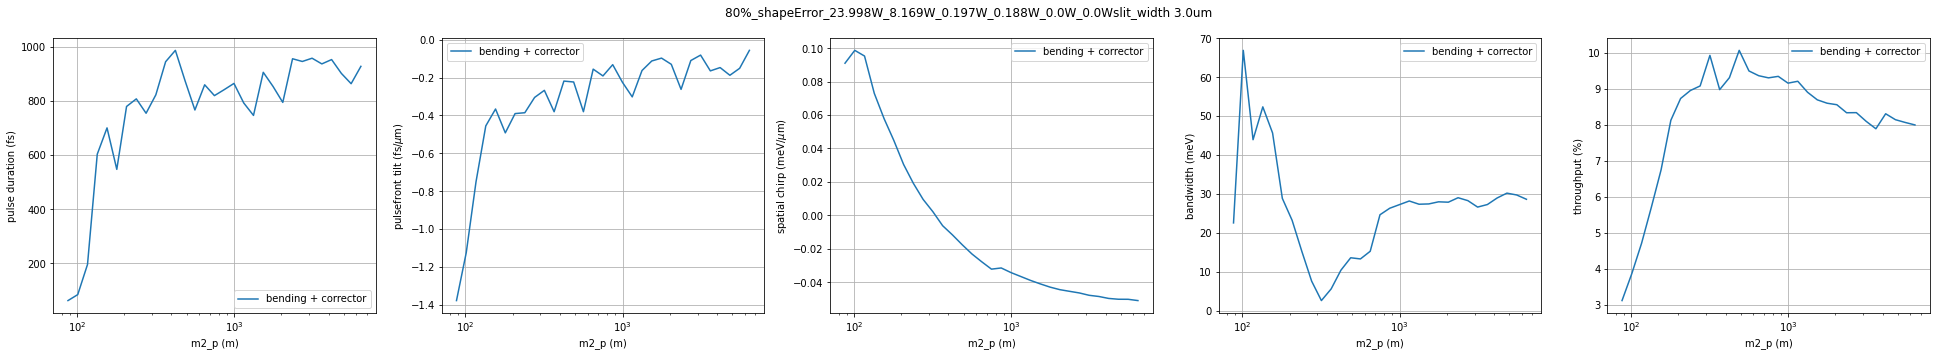

In [16]:
##### Plot

with h5py.File(dir_plot+fname_error+'.h5', 'r') as f:
    m2_p_list = f['m2_p'][:]
    pulse_duration1 = f['pulse_duration'][:]
    pulse_tilt1 = f['tilt'][:]
    spatial_chirp1 = f['chirp'][:]
    energy_bandwidth1 = f['bandwidth'][:]
    throughput1 = f['throughput'][:]

##### plot parameters
plot_axis_x1 = m2_p_list; plot_legend1 = 'bending + corrector'
plot_label_x = 'm2_p (m)'

xmin = m2_p1/10; xmax = m2_p1*10

print(dir_plot)
try:
    result = find_zero(plot_axis_x1, spatial_chirp1, direction='decrease', x_i=m2_p1/5, x_f=m2_p1*5)
    sup_title = fname_error+'_m2_p={}, slit_width {}um'.format(result, slit_width*1e6)
    xmin = plot_axis_x0.min()*0.9; xmax = result*3; xscale = 'log'
    print('m2_p optimized', result)
    
except:
    result = m2_p_list[energy_bandwidth1.argmin()]
    sup_title = fname_error+'slit_width {}um'.format(slit_width*1e6)
    xscale = 'log'

#### plot
plt.figure(figsize=(27,5))
plt.suptitle(sup_title)

# duration
plt.subplot(1,5,1)
plt.plot(plot_axis_x1, pulse_duration1, label=plot_legend1)
plt.xlabel(plot_label_x); plt.ylabel('pulse duration (fs)')
plt.grid(); plt.legend(); plt.tight_layout()
# plt.xlim([xmin, xmax]); plt.ylim([0, 1e4])
plt.xscale(xscale)

# tilt
plt.subplot(1,5,2)
plt.plot(plot_axis_x1, pulse_tilt1, label=plot_legend1)
plt.xlabel(plot_label_x); plt.ylabel(r'pulsefront tilt (fs/$\mu$m)')
plt.grid(); plt.legend(); plt.tight_layout()
# plt.xlim([xmin, xmax]); plt.ylim([-10, 10])
plt.xscale(xscale)

# chirp
plt.subplot(1,5,3)
plt.plot(plot_axis_x1, spatial_chirp1*1000, label=plot_legend1)
plt.xlabel(plot_label_x); plt.ylabel(r'spatial chirp (meV/$\mu$m)')
plt.grid(); plt.legend(); plt.tight_layout()
# plt.xlim([xmin, xmax]); plt.ylim([-5e-2, 5e-2])
plt.xscale(xscale)

# bandwidth
plt.subplot(1,5,4)
plt.plot(plot_axis_x1, energy_bandwidth1*1000, label=plot_legend1)
plt.xlabel(plot_label_x); plt.ylabel('bandwidth (meV)')
plt.grid(); plt.legend(); plt.tight_layout()
# plt.xlim([xmin, xmax]); plt.ylim([0, 20])
plt.xscale(xscale)

# throughput
plt.subplot(1,5,5)
plt.plot(plot_axis_x1, throughput1*100, label=plot_legend1)
plt.xlabel(plot_label_x); plt.ylabel('throughput (%)')
plt.grid(); plt.legend(); plt.tight_layout()
# plt.xlim([xmin, xmax]); plt.ylim([0, 40])
plt.xscale(xscale)

plt.savefig(dir_plot+'Bending_and_corrector_'+fname_error+'.png')
# plt.close('all')

In [17]:
m2_p_list

array([  87.87837735,  101.3883101 ,  116.97518472,  134.95829872,
        155.7060366 ,  179.64341625,  207.26079546,  239.12391686,
        275.88549725,  318.29859846,  367.23205383,  423.68826635,
        488.82374284,  563.97278504,  650.67482282,  750.70594945,
        866.11530487,  999.26705241, 1152.88880869, 1330.12751898,
       1534.61392234, 1770.53692752, 2042.72942273, 2356.76727756,
       2719.08356475, 3137.10034185, 3619.38069224, 4175.80414008,
       4817.76903261, 5558.42603556, 6412.9475248 ])

### Adding time domain simulation and see what pulse looks like after being corrected...

In [28]:
%%capture capt

##### perfect
mono_devices_p, mono_beamline_p = define_beamline_normal(E0,
                           m1_p=m1_p, m1_q=m1_q, m2_p=m2_p,
                           HHLM_type=HHLM_type,
                           HHLM_offset=HHLM_offset,
                           pair_distance=pair_distance,
                           slit_width=slit_width, f1=f1, f2=f2,
                           hkl1=hkl1, alphaAsym1=alphaAsym1,
                           hkl2=hkl2, alphaAsym2=alphaAsym2,
                           hkl3=hkl3, alphaAsym3=alphaAsym3,
                           shapeErrors=[None for i in range(6)],
                           l_crystal=l_crystal,
                           w_crystal=w_crystal)

##### shapeError and mirror bending
mono_devices_m, mono_beamline_m = define_beamline_normal(E0,
                           m1_p=m1_p, m1_q=m1_q, m2_p=m2_p1,
                           HHLM_type=HHLM_type,
                           HHLM_offset=HHLM_offset,
                           pair_distance=pair_distance,
                           slit_width=slit_width, f1=f1, f2=f2,
                           hkl1=hkl1, alphaAsym1=alphaAsym1,
                           hkl2=hkl2, alphaAsym2=alphaAsym2,
                           hkl3=hkl3, alphaAsym3=alphaAsym3,
                           shapeErrors=shapeErrors,
                           l_crystal=l_crystal,
                           w_crystal=w_crystal)

mono_devices_c, mono_beamline_c = define_beamline_phase(E0,
                           m1_p=m1_p, m1_q=m1_q, m2_p=result,
                           HHLM_type=HHLM_type,
                           HHLM_offset=HHLM_offset,
                           pair_distance=pair_distance,
                           slit_width=slit_width, f1=f1, f2=f2,
                           hkl1=hkl1, alphaAsym1=alphaAsym1,
                           hkl2=hkl2, alphaAsym2=alphaAsym2,
                           hkl3=hkl3, alphaAsym3=alphaAsym3,
                           shapeErrors=shapeErrors,
                           l_crystal=l_crystal,
                           w_crystal=w_crystal)


In [29]:
%%capture capt
screen_names = ['im_input','im_after_HHLM4','im_focus','im_output']

# perfect case
beam_params['photonEnergy'] = E0
pulse_p = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=40e-3, N=150)
pulse_p.propagate(beamline=mono_beamline_p,screen_names=screen_names)

# shapeError
beam_params['photonEnergy'] = E0
pulse_m = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=40e-3, N=150)
pulse_m.propagate(beamline=mono_beamline_m,screen_names=screen_names)

# shapeError with phase corrector
beam_params['photonEnergy'] = E0
pulse_c = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=40e-3, N=150)
pulse_c.propagate(beamline=mono_beamline_c,screen_names=screen_names)

dir_profile = dir_plot+'profiles_{}%_bent/'.format(power_percentage); make_dir(dir_profile)

c:\users\nanw0\anaconda3\envs\lcls\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
c:\users\nanw0\anaconda3\envs\lcls\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


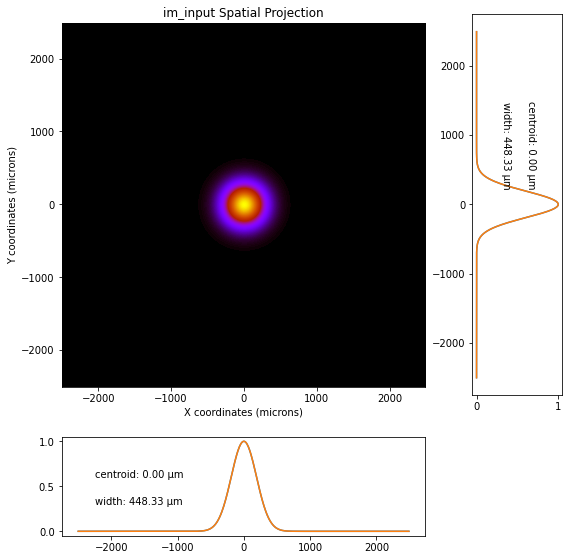

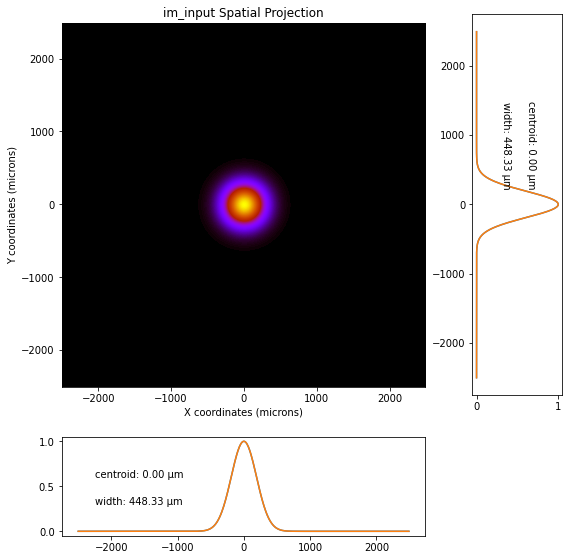

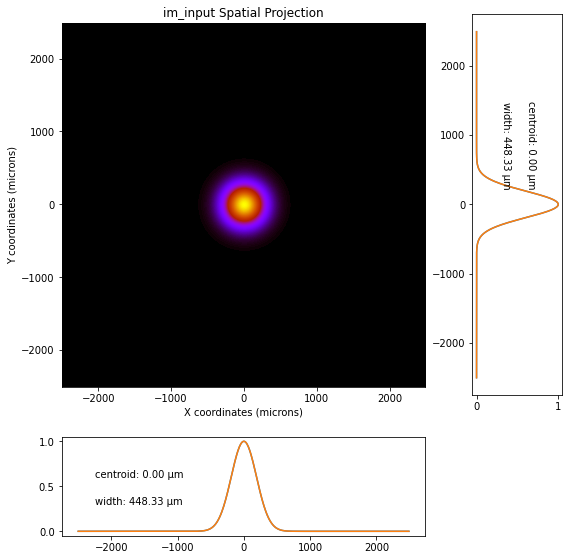

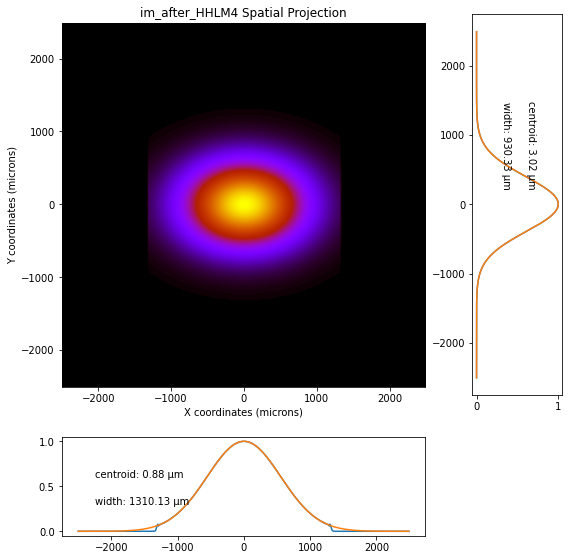

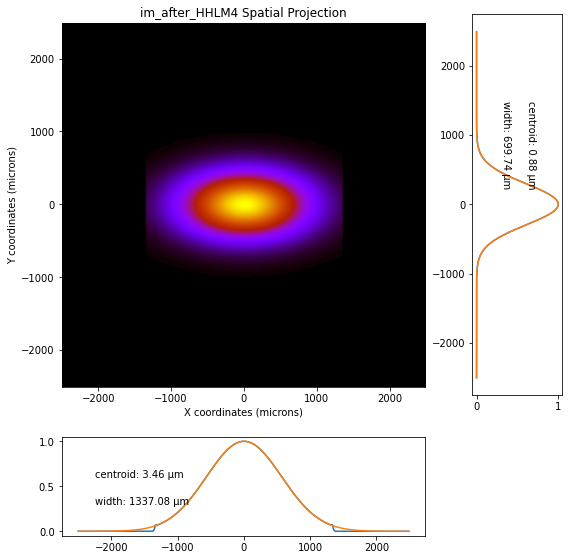

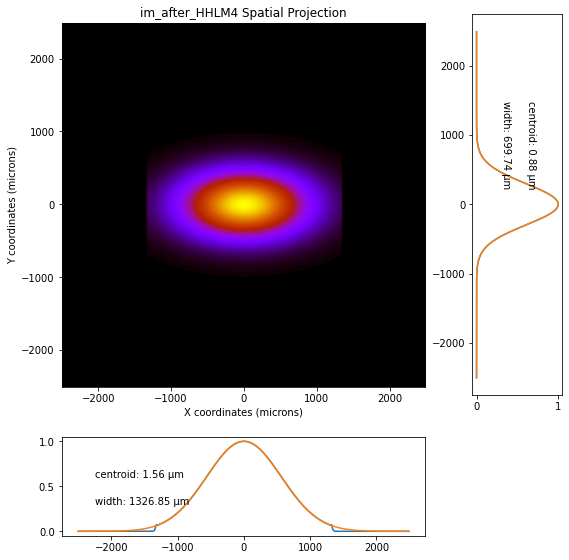

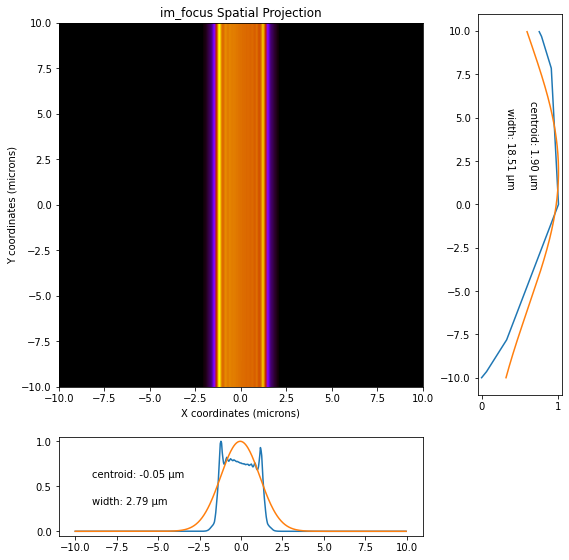

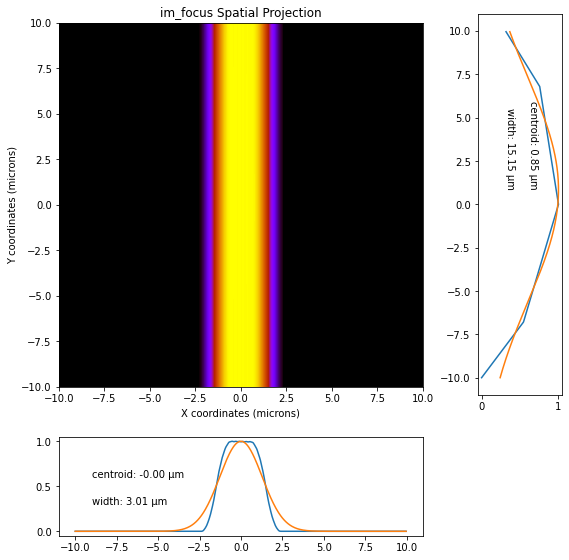

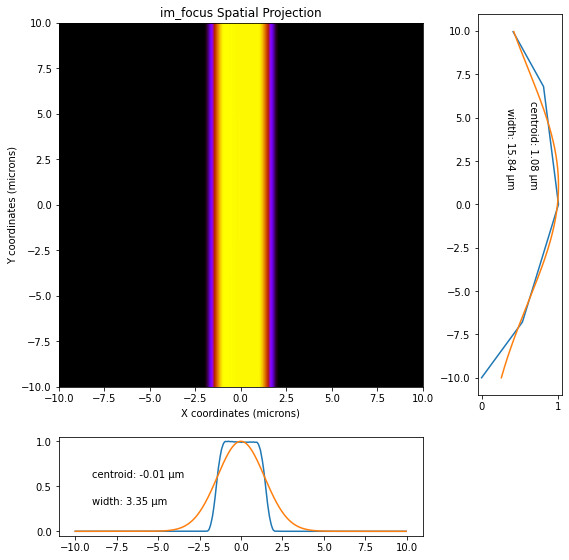

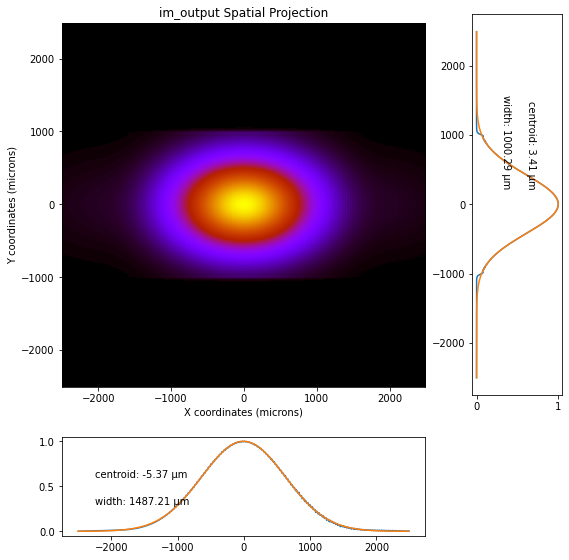

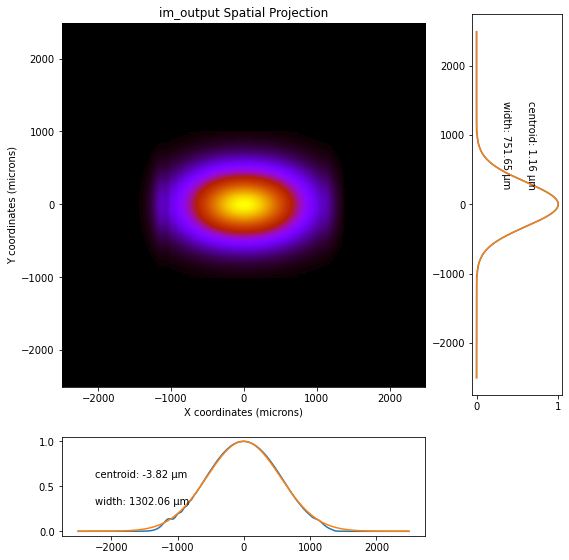

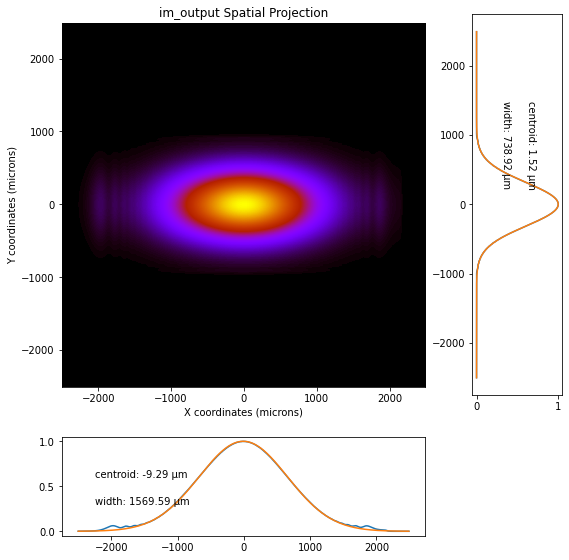

In [30]:
''' projection '''
for i,screen_name in enumerate(screen_names):
    try:
        pulse_p.imshow_projection(screen_name); plt.savefig(dir_profile+'projection_{}_1_perfect.png'.format(i+1))
        pulse_m.imshow_projection(screen_name); plt.savefig(dir_profile+'projection_{}_3_mirror_bending.png'.format(i+1))
        pulse_c.imshow_projection(screen_name); plt.savefig(dir_profile+'projection_{}_5_bending_and_phase_corrector.png'.format(i+1))
    except:
        print(screen_name, 'failed')


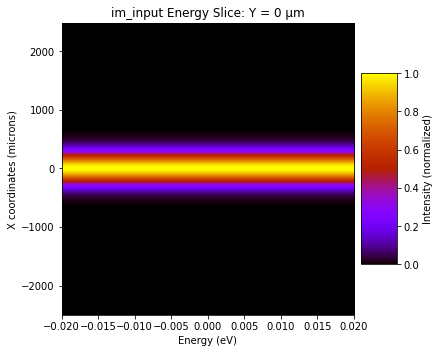

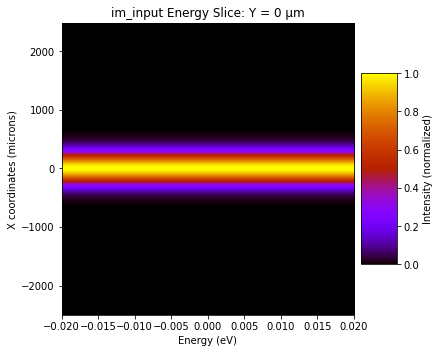

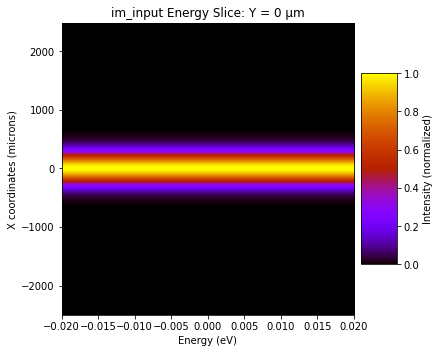

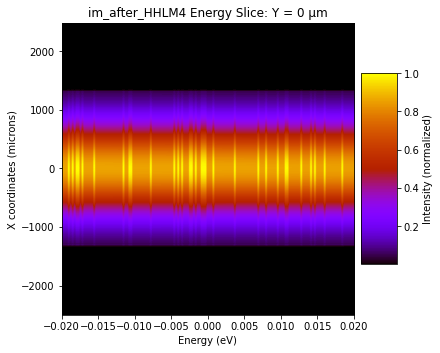

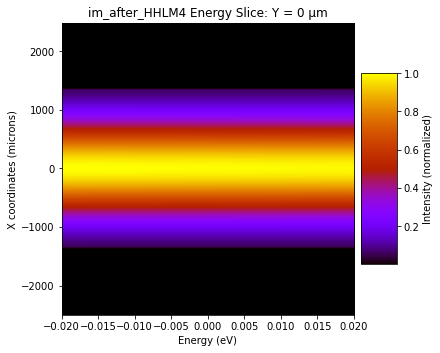

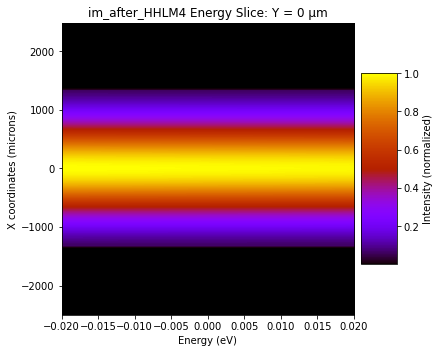

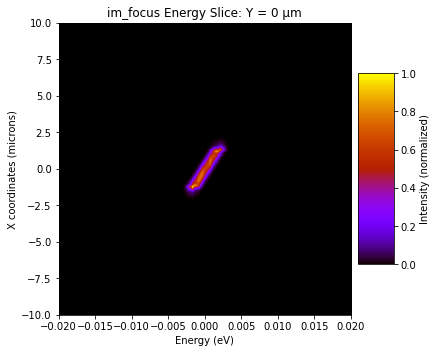

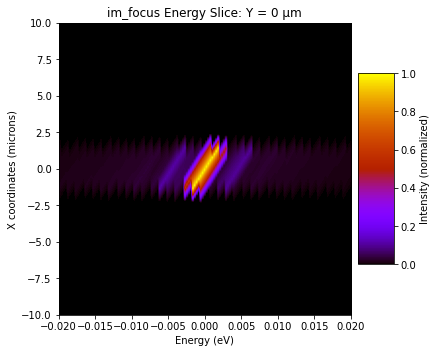

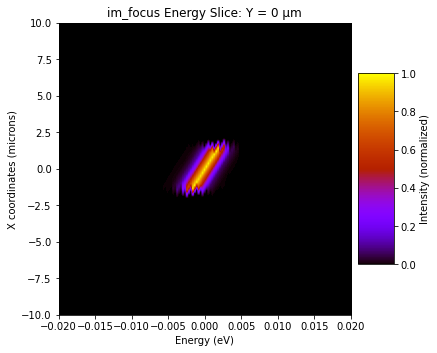

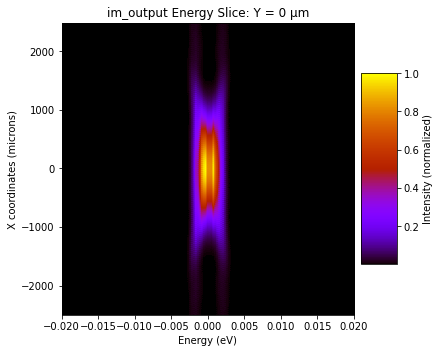

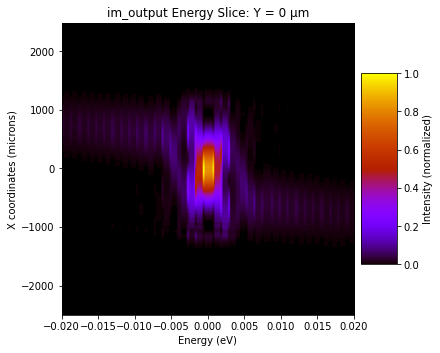

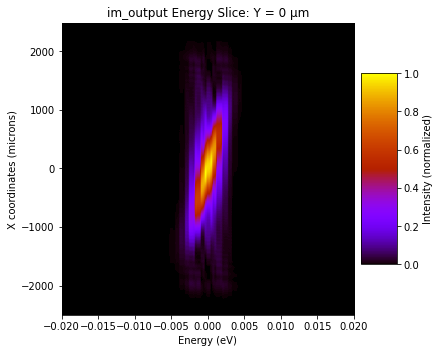

In [31]:
''' energy slices '''
for i,screen_name in enumerate(screen_names):
    try:
        pulse_p.imshow_energy_slice(screen_name); plt.savefig(dir_profile+'spectrum_{}_1_perfect.png'.format(i+1))
        pulse_m.imshow_energy_slice(screen_name); plt.savefig(dir_profile+'spectrum_{}_3_mirror_bending.png'.format(i+1))
        pulse_c.imshow_energy_slice(screen_name); plt.savefig(dir_profile+'spectrum_{}_5_bending_and_phase_corrector.png'.format(i+1))
    except:
        print(screen_name, 'failed')


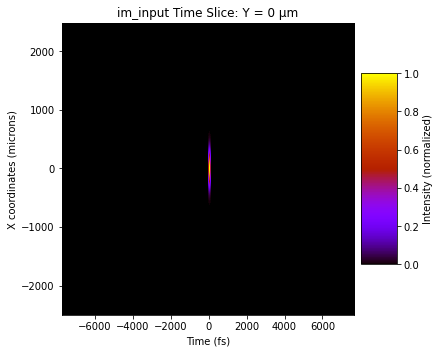

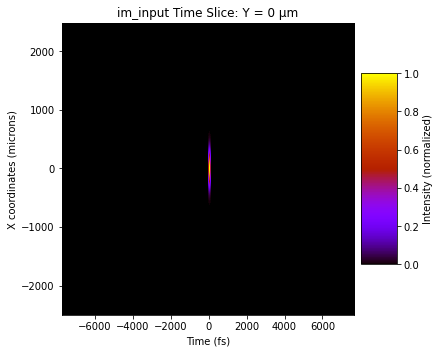

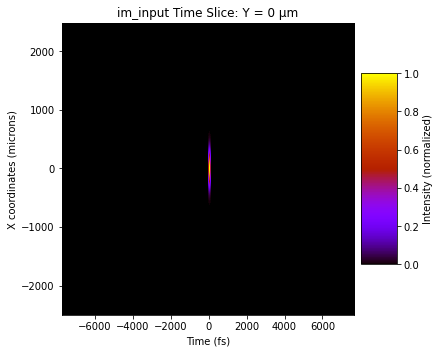

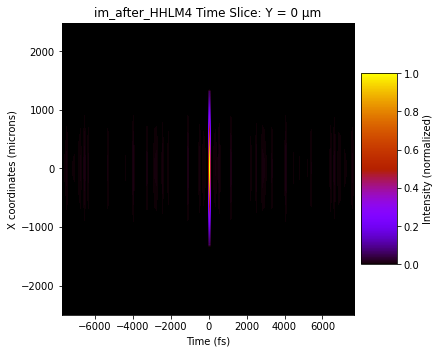

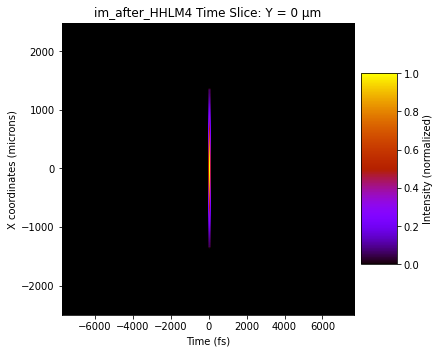

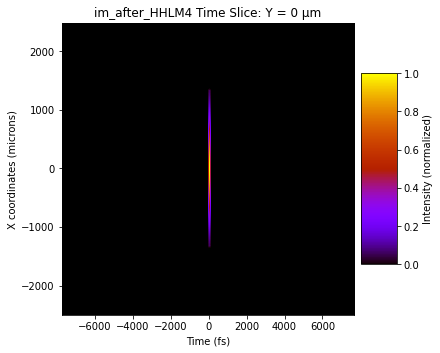

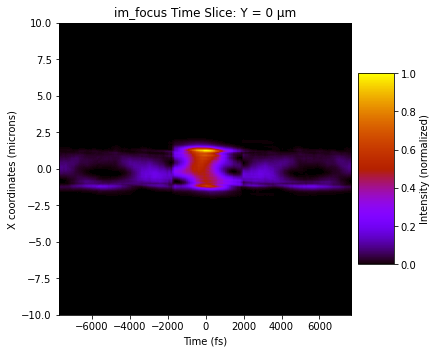

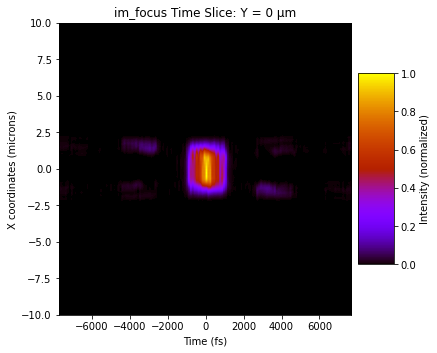

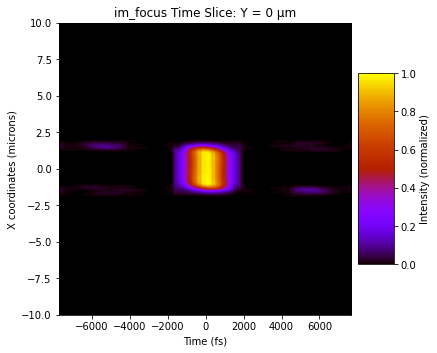

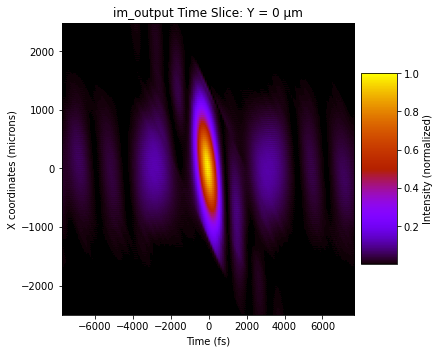

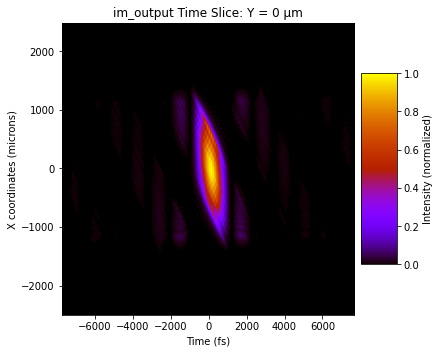

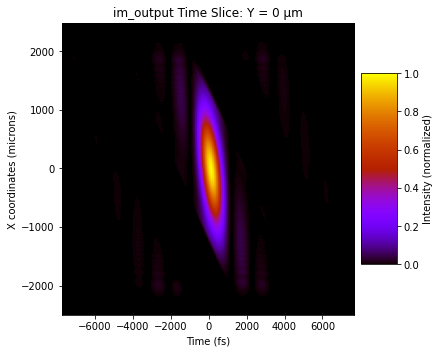

In [32]:
''' plot time slices '''
shift = 0
for i,screen_name in enumerate(screen_names):
    try:
        pulse_p.imshow_time_slice(screen_name, shift=shift); plt.savefig(dir_profile+'tilt_{}_1_perfect.png'.format(i+1))
        pulse_m.imshow_time_slice(screen_name, shift=shift); plt.savefig(dir_profile+'tilt_{}_3_mirror_bending.png'.format(i+1))
        pulse_c.imshow_time_slice(screen_name, shift=shift); plt.savefig(dir_profile+'tilt_{}_5_bending_and_phase_corrector.png'.format(i+1))
    except:
        print(screen_name, 'failed')

In [33]:
''' diagnostics '''
# perfect
c, pulse_duration0 = pulse_p.pulse_duration('im_output')
pulse_tilt0 = pulse_p.pulsefront_tilt('im_output')
spatial_chirp0 = pulse_p.spatial_chirp('im_output')
energy_bandwidth0 = pulse_p.pulse_bandwidth('im_output')
throughput0 = pulse_p.throughput('im_input','im_output')
print('duration {}fs'.format(pulse_duration0))
print('tilt {}fs/um'.format(pulse_tilt0))
print('spatial chirp {}meV/um'.format(spatial_chirp0*1e3))
print('bandwidth {}meV'.format(energy_bandwidth0*1e3))
print('throughput {}%'.format(throughput0*1e2))
np.savetxt(dir_plot+'diagnostics_perfect.txt',np.array([pulse_duration0, pulse_tilt0, spatial_chirp0*1e3, energy_bandwidth0*1e3]), delimiter=',')

# shapeError with phase corrector
c, pulse_duration1 = pulse_c.pulse_duration('im_output')
pulse_tilt1 = pulse_c.pulsefront_tilt('im_output')
spatial_chirp1 = pulse_c.spatial_chirp('im_output')
energy_bandwidth1 = pulse_c.pulse_bandwidth('im_output')
throughput1 = pulse_c.throughput('im_input','im_output')
print('\nduration {}fs'.format(pulse_duration1))
print('tilt {}fs/um'.format(pulse_tilt1))
print('spatial chirp {}meV/um'.format(spatial_chirp1*1e3))
print('bandwidth {}meV'.format(energy_bandwidth1*1e3))
print('throughput {}%'.format(throughput1*1e2))
np.savetxt(dir_plot+'diagnostics_corrector_'+fname_error+'.txt',np.array([pulse_duration1, pulse_tilt1, spatial_chirp1*1e3, energy_bandwidth1*1e3]), delimiter=',')


duration 853fs
tilt -0.3463861486204807fs/um
spatial chirp -2.808694245739442e-05meV/um
bandwidth 2.747497390640747meV
throughput 27.754987814576893%

duration 846fs
tilt -0.33570580906371955fs/um
spatial chirp 0.0021039858906984855meV/um
bandwidth 2.336667053433389meV
throughput 23.166166774655323%


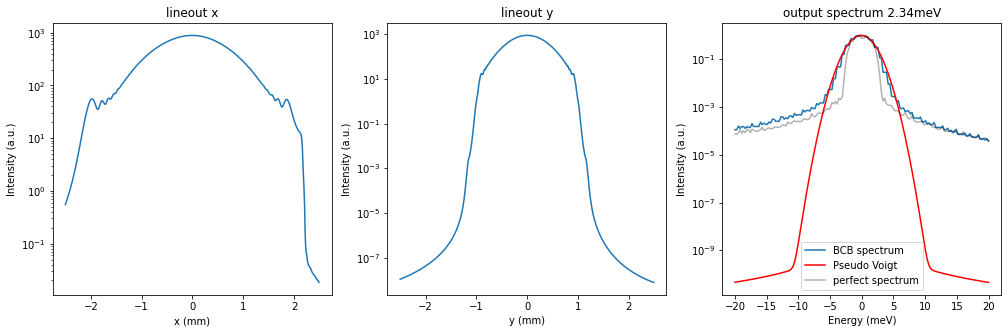

In [53]:
##### 1D spectrum and lineout
axis_eV, spectral_intensity, gauss_fit = get_spectrum(pulse_c, 'im_output', integrated=True)
axis_eV0, spectral_intensity0, _ = get_spectrum(pulse_p, 'im_output', integrated=True)

# PseudoVoigt fit
mod = PseudoVoigtModel()
pars = mod.guess(spectral_intensity, x=axis_eV*1e3)
out = mod.fit(spectral_intensity, pars, x=axis_eV*1e3)

def get_profile(pulse, image_name):
    axis_x = pulse.x[image_name]
    axis_y = pulse.y[image_name]
    profile_2d = np.sum(np.abs(pulse.time_stacks[image_name])**2, axis=-1)
    return axis_x, axis_y, profile_2d

axis_x, axis_y, profile_2d = get_profile(pulse_c, 'im_output')
npts_x, npts_y = profile_2d.shape

plt.figure(figsize=(17,5))

plt.subplot(1,3,1)
plt.plot(axis_x*1e3, profile_2d[int(npts_y/2)])
plt.xlabel('x (mm)'); plt.ylabel('Intensity (a.u.)'); plt.title('lineout x'); plt.yscale('log')

plt.subplot(1,3,2)
plt.plot(axis_y*1e3, profile_2d[:,int(npts_x/2)])
plt.xlabel('y (mm)'); plt.ylabel('Intensity (a.u.)'); plt.title('lineout y'); plt.yscale('log')

plt.subplot(1,3,3)
plt.plot(axis_eV*1e3, spectral_intensity, label='BCB spectrum')
plt.plot(axis_eV*1e3, out.best_fit, 'r-', label='Pseudo Voigt')
plt.plot(axis_eV0*1e3, spectral_intensity0, 'k-', alpha=0.3, label='perfect spectrum')

plt.legend(); plt.xlabel('Energy (meV)'); plt.ylabel('Intensity (a.u.)'); plt.yscale('log')
plt.title('output spectrum {}meV'.format(round(energy_bandwidth1*1e3,2)))

plt.savefig(dir_plot+'spectrum_{}.png'.format(fname_error))


### Pseudo Voigt Function
$$
f(x; A, \mu, \sigma, \alpha) = \frac{(1-\alpha)A}{\sigma_g\sqrt{2\pi}}
e^{[{-{(x-\mu)^2}/{{2\sigma_g}^2}}]}
+ \frac{\alpha A}{\pi} \big[\frac{\sigma}{(x - \mu)^2 + \sigma^2}\big]
$$

In [49]:
### fit result
out.params.pretty_print()


Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude      3.97     -inf      inf  0.08355     True     None     None
center     -0.08511     -inf      inf  0.01901     True     None     None
fraction   7.88e-09        0        1  0.06735     True     None     None
fwhm          3.686     -inf      inf    0.052    False 2.0000000*sigma     None
height        1.012     -inf      inf  0.03944    False (((1-fraction)*amplitude)/max(1e-15, (sigma*sqrt(pi/log(2))))+(fraction*amplitude)/max(1e-15, (pi*sigma)))     None
sigma         1.843        0      inf    0.026     True     None     None


In [36]:
import winsound
winsound.Beep(1500, 3000)